In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import chi2
import matplotlib.pyplot as plt
import os

In [3]:
import sys
sys.path.append("py")

import w8_estimation as est 
import w8_LinearModel as lm
import w8_probit as probit
import w8_logit as logit

## Read data and preliminary data selection

In [4]:
data = pd.read_csv('ppcs_cc.csv')

assert data.notnull().all().all()

print(f'All years are the same: \t{(data['year'] == 2011).all()}') # all variables are for the same year -> drop year as feature

print(f'Dummy trap in officer race: \t{data['omajother'].sum() + data['omajwhite'].sum() + data['omajhisp'].sum() + data['omajblack'].sum() == len(data)}')  # one-hot encoded -> drop one category to avoid multicollinearity

print(f'Dummy trap in civilian race: \t{data['sother'].sum() + data['swhite'].sum() + data['shisp'].sum() + data['sblack'].sum() == len(data)}')  # one-hot encoded -> drop one category to avoid multicollinearity

print(f'osplit is 0 for all obs: \t{data['osplit'].sum() == 0}')  # no variation -> drop feature

data['constant'] = 1

All years are the same: 	True
Dummy trap in officer race: 	True
Dummy trap in civilian race: 	True
osplit is 0 for all obs: 	True


In [5]:
pd.DataFrame({
    "mean": data.mean(),
    "sum": data.sum()
    }).round(2)

,mean,sum
sblack,0.11,420
shisp,0.10,386
swhite,0.74,2808
sother,0.05,185
smale,0.53,2012
sage,41.01,155797
sempl,0.70,2642
sincome,2.16,8224
spop,1.36,5177
daytime,0.67,2532


## Data selection

In [6]:
# types of features
x_labels = ['constant',
 'sblack', # dummy
 'shisp', # dummy
 #'swhite', # dummy -> dropped because of dummy trap: see earlier
 'sother', # dummy 
 'smale', # dummy
 'sage', # continuous / categorical
 'sempl', # dummy
 'sincome', # categorical with numerical interpretation 
 'spop', # categorical with numerical interpretation 
 'daytime', # categorical, non-numerical interpretation
 'inctype_lin', # categorical / dummy?
 #'omajblack', # dummy -> collaped with omajhisp for union dummy to avoid seperation
 #'omajhisp', # dummy -> collaped with omajblack for union dummy to avoid seperation
 #'omajwhite', # dummy
 #'omajother', # dummy -> dropped because of dummy trap: see earlier
 #'osplit', # invariant -> dropped
 #'year' # invariant -> dropped
 'sbehavior', # dummy
 ]

x_labels_imp = ['sblack', 'shisp', 'sother', 'smale', 'daytime', 'sbehavior']

data['omajblackhispother'] = data['omajblack'] + data['omajhisp'] + data['omajother']
x_labels += ['omajblackhispother']

y_label = 'anyuseofforce_coded'

# list of variables to scale or square
scales = ['sage']
squares = []

# square
for var in squares:
    sq_label = var + 'sq'
    data[sq_label] = data[var]**2
    x_labels += [sq_label]

# scale
for var in scales:
    #data[var] = (data[var] - data[var].mean())/data[var].std() # standardization
    data[var] = data[var]/10 # divide by 10 scaling

In [7]:
y = data[y_label]
x = data[x_labels]

In [8]:
y = y.values
x = x.values

In [9]:
assert np.linalg.matrix_rank(x.T @ x) == x.shape[1]  # check for multicollinearity

## Intensive margin: Events with force

In [10]:
data[x_labels][data['anyuseofforce_coded'] == 1]

,constant,sblack,shisp,sother,smale,sage,sempl,sincome,spop,daytime,inctype_lin,sbehavior,omajblackhispother
6,1,1,0,0,1,2.8,0,1,4,1,1,1,0
70,1,0,1,0,1,3.0,1,1,4,0,2,1,0
354,1,1,0,0,1,4.0,0,3,2,1,2,0,0
419,1,0,0,0,1,2.3,1,1,2,1,2,1,0
1011,1,0,0,0,1,2.0,1,3,1,1,2,1,0
1091,1,0,0,0,1,3.4,0,1,1,0,2,1,0
1834,1,0,1,0,1,2.2,0,3,3,0,2,0,0
1958,1,0,1,0,1,4.0,1,1,1,1,1,0,0
2156,1,0,1,0,0,2.6,0,2,4,1,1,1,1
2558,1,1,0,0,1,3.2,1,2,1,1,1,0,0


## Intensive vs. Extensive margin for sage, sincome, spop, inctype_lin, sempl

Variables which are primarly included as controls, which means we will likely average them out later

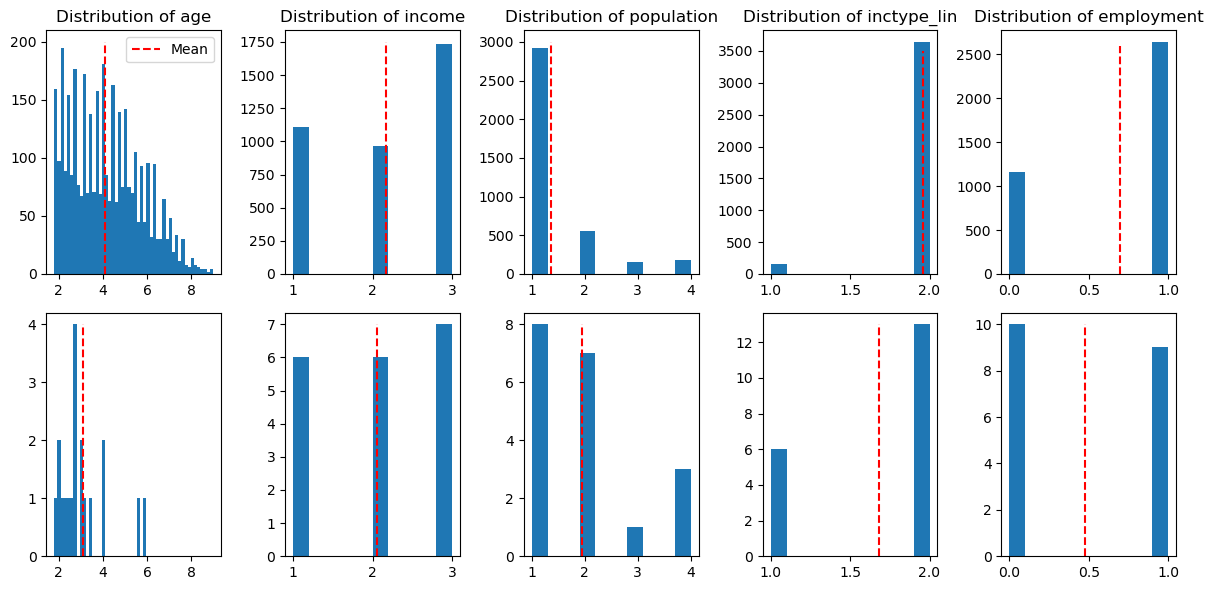

In [11]:
f, ax = plt.subplots(2, 5, figsize=(12, 6))

# extensive margin
ax[0,0].set_title('Distribution of age')
ax[0,0].hist(data['sage'], bins=50, range=[1.8, 9.0])
ax[0,0].vlines(data['sage'].mean(), 0, 200, colors='r', linestyles='dashed', label='Mean') # mean and median overlaps
ax[0,0].legend()

ax[0,1].set_title('Distribution of income')
ax[0,1].hist(data['sincome'])
ax[0,1].vlines(data['sincome'].mean(), 0, 1750, colors='r', linestyles='dashed')

ax[0,2].set_title('Distribution of population')
ax[0,2].hist(data['spop'])
ax[0,2].vlines(data['spop'].mean(), 0, 3000, colors='r', linestyles='dashed')

ax[0,3].set_title('Distribution of inctype_lin')
ax[0,3].hist(data['inctype_lin'])
ax[0,3].vlines(data['inctype_lin'].mean(), 0, 3500, colors='r', linestyles='dashed')

ax[0,4].set_title('Distribution of employment')
ax[0,4].hist(data['sempl'])
ax[0,4].vlines(data['sempl'].mean(), 0, 2600, colors='r', linestyles='dashed')

# intensive margin
ax[1,0].hist(data['sage'][data['anyuseofforce_coded'] == 1], bins=50, range=[1.8, 9.0])
ax[1,0].vlines(data['sage'][data['anyuseofforce_coded'] == 1].mean(), 0, 4, colors='r', linestyles='dashed')

ax[1,1].hist(data['sincome'][data['anyuseofforce_coded'] == 1])
ax[1,1].vlines(data['sincome'][data['anyuseofforce_coded'] == 1].mean(), 0, 7, colors='r', linestyles='dashed')

ax[1,2].hist(data['spop'][data['anyuseofforce_coded'] == 1])
ax[1,2].vlines(data['spop'][data['anyuseofforce_coded'] == 1].mean(), 0, 8, colors='r', linestyles='dashed')

ax[1,3].hist(data['inctype_lin'][data['anyuseofforce_coded'] == 1])
ax[1,3].vlines(data['inctype_lin'][data['anyuseofforce_coded'] == 1].mean(), 0, 13, colors='r', linestyles='dashed')

ax[1,4].hist(data['sempl'][data['anyuseofforce_coded'] == 1])
ax[1,4].vlines(data['sempl'][data['anyuseofforce_coded'] == 1].mean(), 0, 10, colors='r', linestyles='dashed')

f.tight_layout()
f.savefig('IntensivevsExtensiveMargin.png')

In [12]:
print(f'Intensive margin averages:')
print(f'sage:\t\t{data['sage'].mean():.2f}')
print(f'sincome:\t{data['sincome'].mean():.2f}')
print(f'spop:\t\t{data['spop'].mean():.2f}')
print(f'inctype_lin:\t{data['inctype_lin'].mean():.2f}')
print(f'sempl:\t\t{data['sempl'].mean():.2f}')

Intensive margin averages:
sage:		4.10
sincome:	2.16
spop:		1.36
inctype_lin:	1.96
sempl:		0.70


## Linear Probability Model (LPM)

In [13]:
ols_results =  lm.estimate(y, x, robust_se=True)
ols_tab = lm.print_table((y_label, x_labels), ols_results, title='LPM results')
b_lpm = ols_tab.b_hat
b_lpm_se = ols_tab.se
ols_tab

LPM results
Dependent variable: anyuseofforce_coded

R2 = 0.033
sigma2 = nan


,b_hat,se,t
constant,0.0588,0.0288,2.0380
sblack,0.0021,0.0045,0.4630
shisp,0.0091,0.0059,1.5460
sother,-0.0004,0.0058,-0.0631
smale,0.0042,0.0022,1.8891
sage,-0.0016,0.0006,-2.5775
sempl,-0.0056,0.0031,-1.7904
sincome,0.0010,0.0014,0.7011
spop,0.0041,0.0021,1.9498
daytime,-0.0017,0.0029,-0.5889


In [14]:
for alpha in [0.01, 0.05, 0.1]:
    print(f'{alpha} level of significance bears the critical value {norm.ppf(1-alpha/2):.2f}')

0.01 level of significance bears the critical value 2.58
0.05 level of significance bears the critical value 1.96
0.1 level of significance bears the critical value 1.64


## Probit

In [15]:
theta0 = probit.starting_values(y, x)
print(theta0)

[ 0.14698564  0.00525683  0.02274212 -0.00091372  0.01053204 -0.00391
 -0.01398951  0.00238653  0.01029199 -0.00419631 -0.07057062  0.08861737
 -0.0113545 ]


In [16]:
ll = probit.loglikelihood(theta0, y, x)
ll

array([-0.71173031, -0.73033234, -0.71777529, ..., -0.68094346,
       -0.70849233, -0.68313492])

In [17]:
probit_results = est.estimate(probit.q, theta0, y, x, cov_type='Sandwich')

Optimization terminated successfully.
         Current function value: 0.022591
         Iterations: 86
         Function evaluations: 1316
         Gradient evaluations: 94


In [18]:
probit_tab = est.print_table(x_labels, probit_results, title=f'Logit, y = {y_label}')
b_probit = probit_tab.theta
b_probit_se = probit_tab.se
probit_tab

Optimizer succeeded after 86 iter. (1316 func. evals.). Final criterion:  0.02259.
Logit, y = anyuseofforce_coded


,theta,se,t
constant,-1.6578,0.5146,-3.2215
sblack,0.2396,0.3048,0.7861
shisp,0.4375,0.2356,1.8567
sother,0.0663,0.4636,0.1431
smale,0.5432,0.1984,2.7386
sage,-0.1304,0.0605,-2.1549
sempl,-0.4135,0.2086,-1.9824
sincome,0.0965,0.1228,0.7858
spop,0.2106,0.0748,2.8155
daytime,-0.1242,0.1962,-0.6334


## Logit

In [19]:
theta0 = logit.starting_values(y, x)
theta0

array([ 0.23517703,  0.00841092,  0.03638739, -0.00146195,  0.01685126,
       -0.00625601, -0.02238322,  0.00381845,  0.01646719, -0.0067141 ,
       -0.11291299,  0.1417878 , -0.01816721])

In [20]:
logit_results = est.estimate(logit.q, theta0, y, x, cov_type='Sandwich')

Optimization terminated successfully.
         Current function value: 0.022785
         Iterations: 108
         Function evaluations: 1540
         Gradient evaluations: 110


In [21]:
logit_tab = est.print_table(x_labels, logit_results, title=f'Logit, y = {y_label}')
b_logit = logit_tab.theta
b_logit_se = logit_tab.se
logit_tab

Optimizer succeeded after 108 iter. (1540 func. evals.). Final criterion:  0.02279.
Logit, y = anyuseofforce_coded


,theta,se,t
constant,-3.1269,1.3063,-2.3937
sblack,0.4588,0.8315,0.5518
shisp,0.9574,0.6077,1.5754
sother,-0.2277,1.3213,-0.1723
smale,1.0986,0.5478,2.0056
sage,-0.3729,0.1762,-2.1168
sempl,-0.9856,0.6065,-1.6250
sincome,0.1929,0.3388,0.5694
spop,0.5400,0.1943,2.7787
daytime,-0.3474,0.5303,-0.6551


In [22]:
pd.DataFrame({'LPM': b_lpm, 'Probit' : b_probit, 'Logit' : b_logit})

,LPM,Probit,Logit
constant,0.0588,-1.6578,-3.1269
sblack,0.0021,0.2396,0.4588
shisp,0.0091,0.4375,0.9574
sother,-0.0004,0.0663,-0.2277
smale,0.0042,0.5432,1.0986
sage,-0.0016,-0.1304,-0.3729
sempl,-0.0056,-0.4135,-0.9856
sincome,0.0010,0.0965,0.1929
spop,0.0041,0.2106,0.5400
daytime,-0.0017,-0.1242,-0.3474


In [23]:
pd.DataFrame({'LPM': b_lpm_se, 'Probit' : b_probit_se, 'Logit' : b_logit_se})

,LPM,Probit,Logit
constant,0.0288,0.5146,1.3063
sblack,0.0045,0.3048,0.8315
shisp,0.0059,0.2356,0.6077
sother,0.0058,0.4636,1.3213
smale,0.0022,0.1984,0.5478
sage,0.0006,0.0605,0.1762
sempl,0.0031,0.2086,0.6065
sincome,0.0014,0.1228,0.3388
spop,0.0021,0.0748,0.1943
daytime,0.0029,0.1962,0.5303


## Partial effects: Special interest

In [24]:
from aux import compute_special_pes

In [25]:
compute_special_pes

<function aux.compute_special_pes(spec_joe, x_labels, b_probit, b_logit)>

## Average Partial Effects (APE)

In [26]:
from aux import compute_ape

In [27]:
APE = compute_ape(x, data, x_labels, x_labels[1:], b_lpm, b_logit, b_probit)

sblack has same APE and LPM:	True
shisp has same APE and LPM:	True
sother has same APE and LPM:	True
smale has same APE and LPM:	True
sage has same APE and LPM:	False
sempl has same APE and LPM:	True
sincome has same APE and LPM:	True
spop has same APE and LPM:	True
daytime has same APE and LPM:	True
inctype_lin has same APE and LPM:	True
sbehavior has same APE and LPM:	True
omajblackhispother has same APE and LPM:	True


/Users/mikkelrich/advmicro-assignment-3/py/aux.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i, var in enumerate(x_labels_imp): print(f'{var} has same APE and LPM:\t{np.isclose(b_lpm[x_labels.index(var)], APE[i, -1])}')


In [28]:
APE_df = pd.DataFrame(APE, columns = ['Probit', 'Logit', 'LPM'], index=x_labels[1:])

APE_df

,Probit,Logit,LPM
sblack,0.000704,0.011911,0.00210
shisp,0.001436,0.023190,0.00910
sother,-0.000249,0.003121,-0.00040
smale,0.001051,0.024158,0.00420
sage,-0.000044,-0.000596,-0.00016
sempl,-0.001301,-0.020323,-0.00560
sincome,0.000314,0.004671,0.00100
spop,0.000611,0.010243,0.00410
daytime,-0.000403,-0.005783,-0.00170
inctype_lin,-0.014587,-0.058269,-0.02820


## Partial Effects on the Average (PEA) (NOT USED IN FINAL SUBMISSION)

##

In [29]:
from aux import compute_all_pe

In [30]:
b_lpm = ols_tab.b_hat.values
b_probit = probit_tab.theta.values
b_logit = logit_tab.theta.values

cov_lpm = ols_results.get('cov')
cov_probit = probit_results.get('cov')
cov_logit = logit_results.get('cov')

In [31]:
average_joe = x.mean(axis=0)
average_joe_intensive = x[y == 1].mean(axis=0)

#pea, se_pea_delta = compute_all_pe(average_joe, x_labels, data, b_probit, b_logit, cov_probit, cov_logit, do_delta=True)

#pea_intensive, se_pea_intensive_delta = compute_all_pe(average_joe_intensive, x_labels, data, b_probit, b_logit, cov_probit, cov_logit, do_delta=True)

In [32]:
#pea_df = pd.DataFrame(pea,
#                      columns=['Probit', 'Logit'],
#                      index=x_labels)

#pea_intensive_df = pd.DataFrame(pea_intensive,
#                      columns=['Probit', 'Logit'],
#                      index=x_labels)

## Specific Partial Effects of Interest (NOT USED IN FINAL SUBMISSION)

In [33]:
from aux import compute_special_pes

In [34]:
for col in data.columns:
    if col in x_labels:
        print(f'{col}:  {data[col].unique()}')

sblack:  [1 0]
shisp:  [0 1]
sother:  [0 1]
smale:  [1 0]
sage:  [1.8 2.  2.2 2.9 2.8 2.6 2.5 3.  4.1 4.4 4.7 4.8 5.2 1.6 1.7 1.9 2.1 2.4
 2.3 2.7 3.1 3.2 3.3 3.4 3.5 3.9 3.7 3.6 4.  4.3 4.2 4.6 4.5 5.3 5.  5.1
 5.4 5.9 5.7 5.8 5.5 5.6 6.1 6.  6.3 6.4 6.2 6.9 6.8 6.6 7.1 7.2 9.  7.8
 8.3 3.8 4.9 6.5 7.  7.3 7.4 8.5 7.7 8.1 8.  7.6 6.7 7.9 8.6 7.5 8.4 8.2
 8.8 8.9]
sempl:  [0 1]
sincome:  [1 2 3]
spop:  [1 4 3 2]
daytime:  [1 0]
inctype_lin:  [2 1]
sbehavior:  [0 1]
constant:  [1]
omajblackhispother:  [0 1]


General decisions:

$\texttt{omajblackhisp}=0$

$\texttt{omajwhite}=1$

$\texttt{sage}=4.10$

$\texttt{sincome}=2.16$

$\texttt{pop}=1.36$

$\texttt{inctype\_lin}=1.96$

$\texttt{sempl}=0.7$

In [35]:
special_joe = np.array([1.0, # constant
                        np.nan, # sblack
                        np.nan, # shisp
                        np.nan, # sother
                        np.nan, # smale
                        4.10, # sage
                        0.70, # sempl
                        2.16, # sincome
                        1.36, # spop
                        np.nan, # daytime
                        1.96, # inctype_lin
                        np.nan, # sbehavior
                        0.0 # omajblackhispother
                        ])

In [36]:
def print_cases(*args):
    i = 0
    for smale in [0, 1]:
        for daytime in [0, 1]:
            for sbehavior in [0, 1]:
                print(f'row {i}:\t\tsmale={smale}, daytime={daytime}, sbehavior={sbehavior}',*args)
                i += 1

print_cases()

row 0:		smale=0, daytime=0, sbehavior=0
row 1:		smale=0, daytime=0, sbehavior=1
row 2:		smale=0, daytime=1, sbehavior=0
row 3:		smale=0, daytime=1, sbehavior=1
row 4:		smale=1, daytime=0, sbehavior=0
row 5:		smale=1, daytime=0, sbehavior=1
row 6:		smale=1, daytime=1, sbehavior=0
row 7:		smale=1, daytime=1, sbehavior=1


In [37]:
special_pes = compute_special_pes(special_joe, x_labels, b_probit, b_logit)

In [38]:
special_pes_probit = special_pes[..., 0]
special_pes_logit = special_pes[..., 1]

spe_probit_df = pd.DataFrame(special_pes_probit,
                            columns=['White->Black', 'White->Hisp', 'White->Other'])

spe_logit_df = pd.DataFrame(special_pes_logit,
                            columns=['White->Black', 'White->Hisp', 'White->Other'])

In [39]:
spe_probit_df

,White->Black,White->Hisp,White->Other
0,0.000431,0.001138,0.000087
1,0.008013,0.018492,0.001805
2,0.000284,0.000764,0.000057
3,0.006035,0.014141,0.001343
4,0.002208,0.005435,0.000473
5,0.023110,0.050000,0.005482
6,0.001559,0.003900,0.000330
7,0.018615,0.040862,0.004364


In [40]:
spe_logit_df

,White->Black,White->Hisp,White->Other
0,0.000447,0.001230,-0.000156
1,0.005811,0.015857,-0.002049
2,0.000316,0.000870,-0.000110
3,0.004137,0.011323,-0.001455
4,0.001334,0.003670,-0.000468
5,0.016558,0.044319,-0.005928
6,0.000944,0.002599,-0.000331
7,0.011965,0.032291,-0.004255


## Bootstrapping

In [41]:
from aux import boot

In [42]:
generate_results = False

In [43]:
if generate_results:
    b_lpm_boot, b_probit_boot, b_logit_boot, ape_boot, sub_events = boot(y, x, special_joe, data, x_labels, x_labels_imp, nboot=1000)

In [44]:
folder = 'BS_results'

if generate_results:

    os.makedirs(folder, exist_ok=True)

    np.save(folder + '/b_lpm_boot', b_lpm_boot)
    np.save(folder + '/b_logit_boot', b_logit_boot)
    np.save(folder + '/b_probit_boot', b_probit_boot)

    #np.save(folder + '/special_pes_boot', special_pes_boot)
    np.save(folder + '/ape_boot', ape_boot)

else:

    b_lpm_boot = np.load(folder + '/b_lpm_boot.npy')
    b_probit_boot = np.load(folder + '/b_probit_boot.npy')
    b_logit_boot = np.load(folder + '/b_logit_boot.npy')
    
    #special_pes_boot = np.load(folder + '/special_pes_boot.npy')
    ape_boot = np.load(folder + '/ape_boot.npy')

## Standard errors of APE

In [45]:
se_ape = ape_boot.std(axis=0)

se_ape_df = pd.DataFrame(se_ape, columns=['LPM', 'Probit', 'Logit'], index=x_labels[1:])

se_ape_df

ValueError: Shape of passed values is (6, 3), indices imply (12, 3)

## sblack bootstrapping distributions across methods

Text(0.5, 1.0, 'LPM')

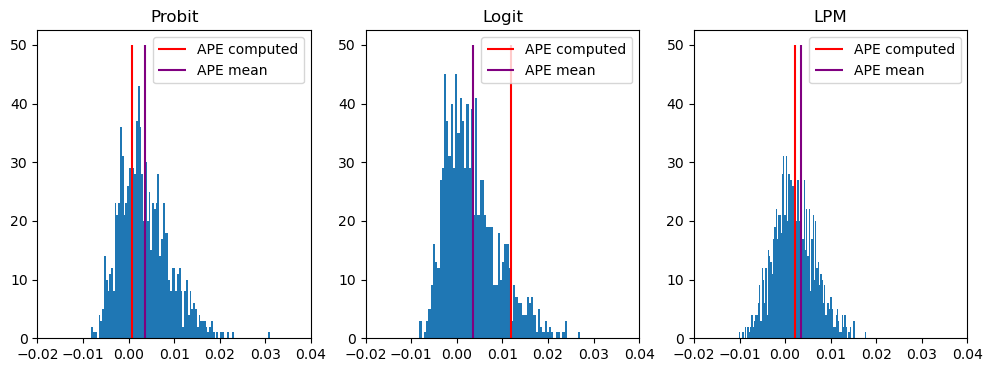

In [ ]:
f, ax = plt.subplots(1,3, figsize=(12, 4))
for i in range(3):
    ax[i].hist(ape_boot[:, 0, i], bins=100)
    ax[i].vlines(APE[0, i], 0, 50, color='red', label='APE computed')
    ax[i].vlines(ape_boot[:, 0, 0].mean(), 0, 50, color='purple', label='APE mean')
    ax[i].set_xlim([-0.02,0.04])
    ax[i].legend()

ax[0].set_title('Probit')
ax[1].set_title('Logit')
ax[2].set_title('LPM')

## Unpacking standard errors from bootstrapping

### Standard errors for LPM, Probit, Logit estimators

In [ ]:
se_lpm_bs = b_lpm_boot.std(axis=0)
se_probit_bs = b_probit_boot.std(axis=0)
se_logit_bs = b_logit_boot.std(axis=0)

se_bs = pd.DataFrame(np.column_stack((se_lpm_bs, se_probit_bs, se_logit_bs)),
                     columns=['LPM', 'Probit', 'Logit'],
                     index=x_labels)

se_bs

,LPM,Probit,Logit
constant,0.027374,0.820415,1.946719
sblack,0.004477,0.828271,2.107162
shisp,0.006096,0.382495,0.868002
sother,0.005925,2.166667,4.783888
smale,0.002259,0.555938,1.290335
sage,0.000621,0.084700,0.216630
sempl,0.003155,0.281014,0.757535
sincome,0.001374,0.150366,0.389800
spop,0.002052,0.093703,0.236399
daytime,0.002763,0.239205,0.613911


### Covariance matrices in LPM, Probit, Logit estimators

In [ ]:
cov_lpm_bs = np.cov(b_lpm_boot, rowvar=False)
cov_probit_bs = np.cov(b_probit_boot, rowvar=False)
cov_logit_bs = np.cov(b_logit_boot, rowvar=False)

### Standard errors for special PE of interest (NOT USED IN FINAL SUBMISSION)

In [ ]:
#se_spe_bs = special_pes_boot.std(axis=0)

NameError: name 'special_pes_boot' is not defined

In [ ]:
#se_spe_bs_probit = se_spe_bs[..., 0]
#se_spe_bs_logit = se_spe_bs[..., 1]

#se_spe_bs_probit_df = pd.DataFrame(se_spe_bs_probit,
#                            columns=['White->Black', 'White->Hisp', 'White->Other'])

#se_spe_bs_logit_df = pd.DataFrame(se_spe_bs_logit,
#                            columns=['White->Black', 'White->Hisp', 'White->Other'])

### Covariance matrices in Special PE of Interest (NOT IN FINAL SUBMISSION)

In [ ]:
#special_pes_boot_probit = special_pes_boot[..., 0]
#special_pes_boot_logit = special_pes_boot[..., 1]

#cov_special_boot_probit = np.zeros((8, 3, 3)) + np.nan
#cov_special_boot_logit = np.zeros((8, 3, 3)) + np.nan

#for i in range(8): cov_special_boot_probit[i, :, :] = np.cov(special_pes_boot_probit[:, i, :], rowvar=False)
#for i in range(8): cov_special_boot_logit[i, :, :] = np.cov(special_pes_boot_logit[:, i, :], rowvar=False)

In [ ]:
#cov_special_boot_probit = np.cov(special_pes_boot_probit[..., 0], rowvar=False)
#cov_special_boot_logit = np.cov(special_pes_boot_logit[..., 1], rowvar=False)

## Wald test of LPM, Probit, Logit

In [ ]:
# H1
R = np.zeros((3,len(x_labels)))
R[0,1], R[1,2], R[2,3] = 1, 1, 1

# H2
#R = np.zeros((2,len(x_labels)))
#R[0,1], R[1,2] = 1,1 #,  R[2,3] = 1, 1, 1
#R[0,2], R[1,3] = -1, -1

R

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
df = R.shape[0]
crit_v = chi2.ppf(1-0.05, df)
print(f'With df = {df} => Critical value is {crit_v:.2f}')

With df = 3 => Critical value is 7.81


### LPM

In [ ]:
bread = R@np.array(b_lpm).reshape(-1,1)
meat = R@cov_lpm_bs@R.T
w = (bread.T @ np.linalg.inv(meat) @ bread)[0,0]

print(f'Test statistic is {w:.2f}')
print(f'Significance = {w > crit_v}')
print(f'p-value is {1-chi2.cdf(w, df):.2f}')

Test statistic is 2.49
Significance = False
p-value is 0.48


### Probit

In [ ]:
bread = R@np.array(b_probit).reshape(-1,1)
meat = R@cov_probit_bs@R.T
w = (bread.T @ np.linalg.inv(meat) @ bread)[0,0]

print(f'Test statistic is {w:.2f}')
print(f'Significance = {w > crit_v}')
print(f'p-value is {1-chi2.cdf(w, df):.2f}')

Test statistic is 1.36
Significance = False
p-value is 0.72


### Logit

In [ ]:
bread = R@np.array(b_logit).reshape(-1,1)
meat = R@cov_logit_bs@R.T
w = (bread.T @ np.linalg.inv(meat) @ bread)[0,0]

print(f'Test statistic is {w:.2f}')
print(f'Significance = {w > crit_v}')
print(f'p-value is {1-chi2.cdf(w, df):.2f}')

Test statistic is 1.27
Significance = False
p-value is 0.74


### LPM: MLE-variance

In [ ]:
bread = R@np.array(b_lpm).reshape(-1,1)
meat = R@cov_lpm@R.T
w = (bread.T @ np.linalg.inv(meat) @ bread)[0,0]

print(f'Test statistic is {w:.2f}')
print(f'Significance = {w > crit_v}')
print(f'p-value is {1-chi2.cdf(w, df):.2f}')

Test statistic is 2.66
Significance = False
p-value is 0.45


### Probit: MLE-variance

In [ ]:
bread = R@np.array(b_lpm).reshape(-1,1)
meat = R@cov_probit@R.T
w = (bread.T @ np.linalg.inv(meat) @ bread)[0,0]

print(f'Test statistic is {w:.2f}')
print(f'Significance = {w > crit_v}')
print(f'p-value is {1-chi2.cdf(w, df):.2f}')

Test statistic is 0.00
Significance = False
p-value is 1.00


### Logit: MLE-variance

In [ ]:
bread = R@np.array(b_lpm).reshape(-1,1)
meat = R@cov_logit@R.T
w = (bread.T @ np.linalg.inv(meat) @ bread)[0,0]

print(f'Test statistic is {w:.2f}')
print(f'Significance = {w > crit_v}')
print(f'p-value is {1-chi2.cdf(w, df):.2f}')

Test statistic is 0.00
Significance = False
p-value is 1.00


## Wald test of special PEs of Interest

In [ ]:
#R = np.diag(np.ones((8,8)))
#cov_special_boot_probit.shape

In [ ]:
#bread = R@special_pes_probit[:, 0].reshape(-1,1)
#R@cov_special_boot_probit@R.T

In [ ]:
#special_pes_probit_wald = np.zeros(8) + np.nan

#for i in range(8):
#    bread = R@special_pes_probit[i].reshape(-1,1)
#    meat = R@cov_special_boot_probit[i]@R.T
#
#    special_pes_probit_wald[i] = (bread.T @ np.linalg.inv(meat) @ bread)[0,0]

#print(f'Wald test statistics are:\n{special_pes_probit_wald}\n')

#print(f'Significance on 5 pct. level:\n{special_pes_probit_wald > chi2_cric_3df}\n')

#print(f'p-values are:\n{1-chi2.cdf(special_pes_probit_wald, 3)}')

In [ ]:
#special_pes_logit = special_pes[...,1]

In [ ]:
#special_pes_logit_wald = np.zeros(8) + np.nan

#for i in range(8):
#    bread = R@special_pes_logit[i].reshape(-1,1)
#    meat = R@cov_special_boot_logit[i]@R.T
#
#    special_pes_logit_wald[i] = (bread.T @ np.linalg.inv(meat) @ bread)[0,0]

#print(f'Wald test statistics are:\n{special_pes_logit_wald}\n')

#print(f'Significance on 5 pct. level:\n{special_pes_logit_wald > chi2_cric_3df}\n')

#print(f'p-values are:\n{1-chi2.cdf(special_pes_logit_wald, 3)}')